In [10]:
import xarray as xr
from shapely.geometry import Polygon
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pyproj
import scipy
from scipy.signal import savgol_filter
from dask.distributed import Client
import dask
import rasterio as rio
import numpy as np
import seaborn as sb
import sys
from importlib import reload
sys.path.append('..')
from hyspexutil.data import munge
from hyspexutil.features import bandutil459 as bu
from hyspexutil.data import datautil459 as du

In [3]:
reload(munge)

<module 'hyspexutil.data.munge' from '/Users/christine/Projects/spectral_analysis/hyspexutil/data/munge.py'>

In [4]:
sb.set_context("talk") 

In [52]:
sb.set(rc = {'figure.figsize':(10,8)})
sb.set_context("poster")
sb.set_style("white") 
sb.set_style('ticks') 

In [38]:
pd.set_option('display.max_rows', 100)

In [39]:
datadir = Path("/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/HySpex_data_extracted/")
spectra_forplot = pd.read_pickle(datadir / "spectra_forplot.pkl.gz")

In [40]:
spectra_forplot

,fid,species,event,flightline,vegclass,context,spectrum
0,559,white spruce,20210803-BC,04,None,crown,"[108.0, 148.0, 109.0, 138.0, 115.0, 126.0, 127..."
1,562,white spruce,20210803-BC,04,None,crown,"[153.0, 163.0, 192.0, 198.0, 207.0, 211.0, 248..."
2,566,paper birch,20210803-BC,04,None,crown,"[78.0, 74.0, 58.0, 86.0, 82.0, 94.0, 89.0, 142..."
3,568,paper birch,20210803-BC,04,Bluejoint,crown,"[59.0, 57.0, 67.0, 95.0, 100.0, 92.0, 133.0, 1..."
4,571,paper birch,20210803-BC,04,Bluejoint,crown,"[104.0, 113.0, 86.0, 128.0, 137.0, 130.0, 140...."
...,...,...,...,...,...,...,...
114,661,paper birch,20200830-BC,02,Closed Spruce/Paper Birch Forest,crown,"[73.0, 41.0, 55.0, 73.0, 81.0, 56.0, 77.0, 136..."
115,659,paper birch,20200830-BC,02,Closed Spruce/Paper Birch Forest,crown,"[25.0, 21.0, 42.0, 81.0, 69.0, 120.0, 94.0, 11..."
116,689,graminoid,20210803-BC,02,Wet sedge meadow,open,"[128.0, 151.0, 124.0, 107.0, 161.0, 135.0, 180..."
117,685,graminoid,20210803-BC,02,Wet sedge meadow,open,"[152.0, 124.0, 163.0, 155.0, 169.0, 193.0, 238..."


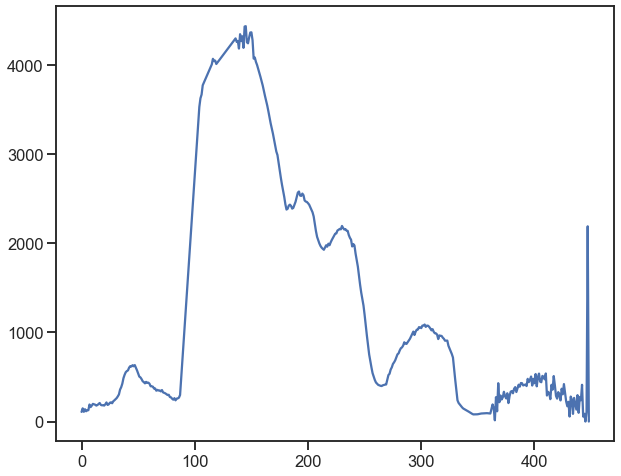

In [44]:
plt.plot(spectra_forplot.iloc[0].spectrum)

---


In [11]:
selected_band_idx = bu.mlbands - 1 
hyspex_wavelengths = du.wavelengths

In [12]:
hyspex_wavelengths[selected_band_idx]

array([1541.68,  435.71, 1259.08,  682.95, 1307.99, 1987.31,  743.17,
        629.06, 1715.58, 2253.6 ,  530.8 , 1003.66, 2025.35,  423.04,
       1193.87,  556.16, 1764.49, 2275.34,  740.  ,  670.27, 1742.76,
       1552.55,  467.41, 1291.69,  600.54, 1721.02,  888.97, 2019.92,
        489.6 , 1661.24, 2259.03,  537.15, 1030.83,  676.61, 1634.07,
       1547.11,  429.38, 1307.99, 2318.81,  740.  ])

PLOTTING

In [13]:
spectra_forplot

,fid,species,event,flightline,vegclass,context,spectrum
0,559,white spruce,20210803-BC,04,None,crown,"[108.0, 148.0, 109.0, 138.0, 115.0, 126.0, 127..."
1,562,white spruce,20210803-BC,04,None,crown,"[153.0, 163.0, 192.0, 198.0, 207.0, 211.0, 248..."
2,566,paper birch,20210803-BC,04,None,crown,"[78.0, 74.0, 58.0, 86.0, 82.0, 94.0, 89.0, 142..."
3,568,paper birch,20210803-BC,04,Bluejoint,crown,"[59.0, 57.0, 67.0, 95.0, 100.0, 92.0, 133.0, 1..."
4,571,paper birch,20210803-BC,04,Bluejoint,crown,"[104.0, 113.0, 86.0, 128.0, 137.0, 130.0, 140...."
...,...,...,...,...,...,...,...
114,661,paper birch,20200830-BC,02,Closed Spruce/Paper Birch Forest,crown,"[73.0, 41.0, 55.0, 73.0, 81.0, 56.0, 77.0, 136..."
115,659,paper birch,20200830-BC,02,Closed Spruce/Paper Birch Forest,crown,"[25.0, 21.0, 42.0, 81.0, 69.0, 120.0, 94.0, 11..."
116,689,graminoid,20210803-BC,02,Wet sedge meadow,open,"[128.0, 151.0, 124.0, 107.0, 161.0, 135.0, 180..."
117,685,graminoid,20210803-BC,02,Wet sedge meadow,open,"[152.0, 124.0, 163.0, 155.0, 169.0, 193.0, 238..."


In [16]:
birch_2021 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_forplot[(spectra_forplot['species']=="paper birch") & (spectra_forplot['context']=="crown") & (spectra_forplot['event']=='20210803-BC')].spectrum ])
birch_2020 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_forplot[(spectra_forplot['species']=="paper birch") & (spectra_forplot['context']=="crown") & (spectra_forplot['event']=='20200830-BC')].spectrum ])
aspen_2021 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_forplot[(spectra_forplot['species']=="quaking aspen") & (spectra_forplot['context']=="crown")  & (spectra_forplot['event']=='20210803-BC')].spectrum ])
aspen_2020 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_forplot[(spectra_forplot['species']=="quaking aspen") & (spectra_forplot['context']=="crown")  & (spectra_forplot['event']=='20200830-BC')].spectrum ])
bspruce_2021 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_forplot[(spectra_forplot['species']=="black spruce")  & (spectra_forplot['context']=="crown")  & (spectra_forplot['event']=='20210803-BC')].spectrum ])
bspruce_2020 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_forplot[(spectra_forplot['species']=="black spruce") & (spectra_forplot['context']=="crown")  & (spectra_forplot['event']=='20200830-BC')].spectrum ])
wspruce_2021 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_forplot[(spectra_forplot['species']=="white spruce") & (spectra_forplot['context']=="crown")  & (spectra_forplot['event']=='20210803-BC')].spectrum ])
wspruce_2020 = pd.DataFrame.from_records([ spectrum for spectrum in spectra_forplot[(spectra_forplot['species']=="white spruce") & (spectra_forplot['context']=="crown")  & (spectra_forplot['event']=='20200830-BC')].spectrum ])

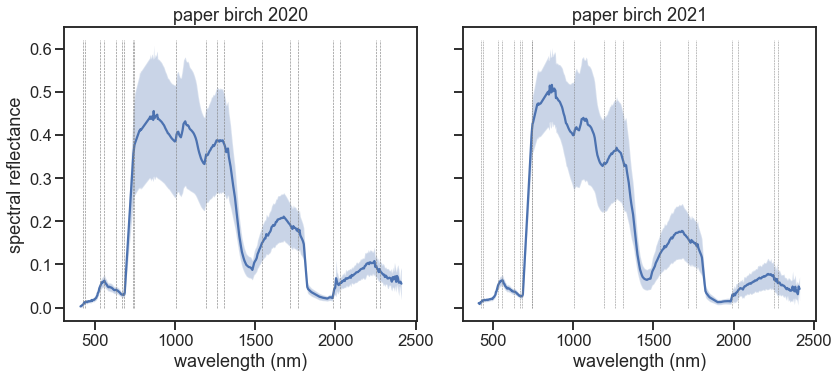

In [45]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharey=True)

x = hyspex_wavelengths[:-18]
y = birch_2020.mean(axis=0).values[:-8]/10000
err = birch_2020.std(axis=0).values[:-8]/10000
axs[0, 0].plot(x, y)
axs[0, 0].fill_between(x, y-err, y+err,
    alpha=0.3,)
x = hyspex_wavelengths[:-18]
y = birch_2021.mean(axis=0).values[:-8]/10000
err = birch_2021.std(axis=0).values[:-8]/10000
axs[0, 1].plot(x, y)
axs[0, 1].fill_between(x, y-err, y+err,
    alpha=0.3)

axs[0, 0].set_ylabel("spectral reflectance")
axs[0, 0].set_xlabel("wavelength (nm)") 
axs[0, 0].set_title("paper birch 2020") 
axs[0, 1].set_xlabel("wavelength (nm)") 
axs[0, 1].set_title("paper birch 2021") 
axs[1, 0].set_visible(False) 
axs[1, 1].set_visible(False) 
axs[2, 0].set_visible(False) 
axs[2, 1].set_visible(False) 

axs[0, 0].vlines(x=hyspex_wavelengths[selected_band_idx[:-20]], ymin=0, ymax=0.62, colors='grey', ls='--', lw=0.6)
axs[0, 1].vlines(x=hyspex_wavelengths[selected_band_idx[:-20]], ymin=0, ymax=0.62, colors='grey', ls='--', lw=0.5)

plt.tight_layout()   

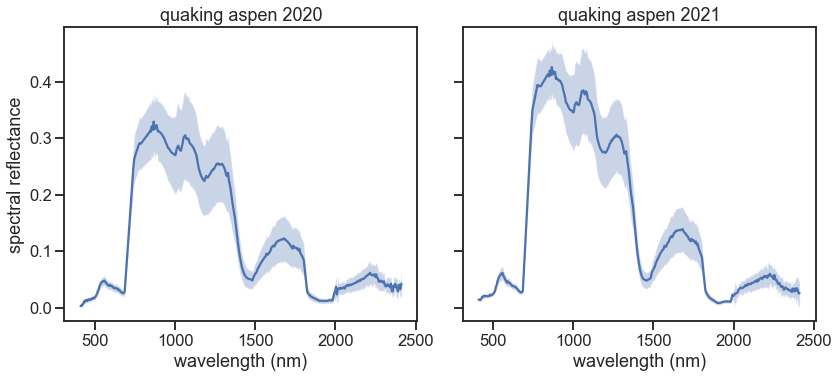

In [46]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharey=True)

x = hyspex_wavelengths[:-18]
y = aspen_2020.mean(axis=0).values[:-8]/10000
err = aspen_2020.std(axis=0).values[:-8]/10000
axs[0, 0].plot(x, y)
axs[0, 0].fill_between(x, y-err, y+err,
    alpha=0.3,)
x = hyspex_wavelengths[:-18]
y = aspen_2021.mean(axis=0).values[:-8]/10000
err = aspen_2021.std(axis=0).values[:-8]/10000
axs[0, 1].plot(x, y)
axs[0, 1].fill_between(x, y-err, y+err,
    alpha=0.3)

axs[0, 0].set_ylabel("spectral reflectance")
axs[0, 0].set_xlabel("wavelength (nm)") 
axs[0, 0].set_title("quaking aspen 2020") 
axs[0, 1].set_xlabel("wavelength (nm)") 
axs[0, 1].set_title("quaking aspen 2021") 
axs[1, 0].set_visible(False) 
axs[1, 1].set_visible(False) 
axs[2, 0].set_visible(False) 
axs[2, 1].set_visible(False) 

plt.tight_layout() 

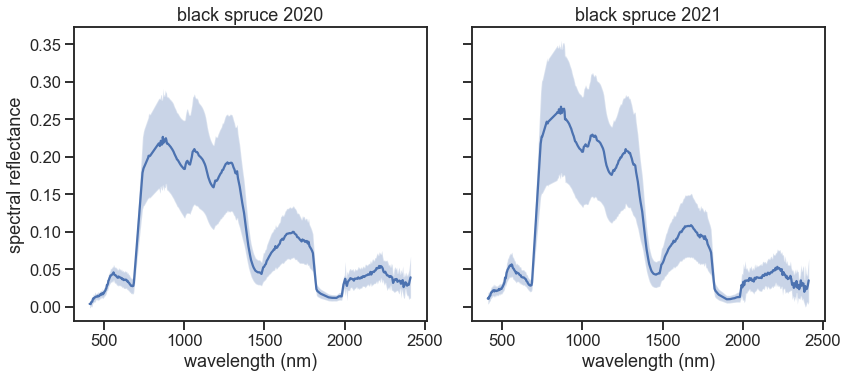

In [47]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharey=True)

x = hyspex_wavelengths[:-18]
y = bspruce_2020.mean(axis=0).values[:-8]/10000
err = bspruce_2020.std(axis=0).values[:-8]/10000
axs[0, 0].plot(x, y)
axs[0, 0].fill_between(x, y-err, y+err,
    alpha=0.3,)
x = hyspex_wavelengths[:-18]
y = bspruce_2021.mean(axis=0).values[:-8]/10000
err = bspruce_2021.std(axis=0).values[:-8]/10000
axs[0, 1].plot(x, y)
axs[0, 1].fill_between(x, y-err, y+err,
    alpha=0.3)

axs[0, 0].set_ylabel("spectral reflectance")
axs[0, 0].set_xlabel("wavelength (nm)") 
axs[0, 0].set_title("black spruce 2020") 
axs[0, 1].set_xlabel("wavelength (nm)") 
axs[0, 1].set_title("black spruce 2021") 
axs[1, 0].set_visible(False) 
axs[1, 1].set_visible(False) 
axs[2, 0].set_visible(False) 
axs[2, 1].set_visible(False) 

plt.tight_layout() 

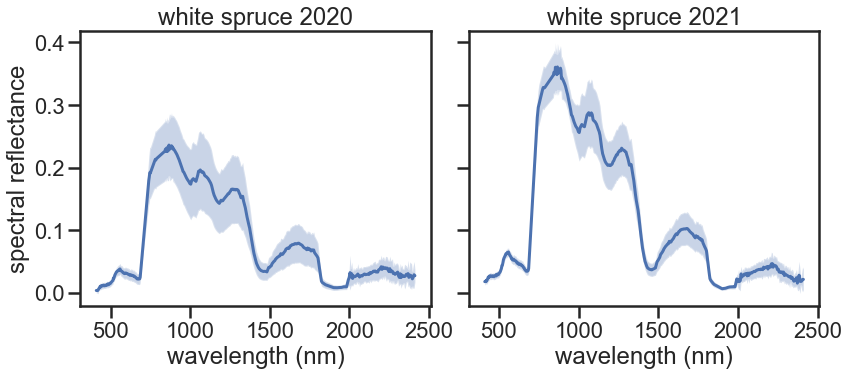

In [53]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharey=True)

x = hyspex_wavelengths[:-18]
y = wspruce_2020.mean(axis=0).values[:-8]/10000
err = wspruce_2020.std(axis=0).values[:-8]/10000
axs[0, 0].plot(x, y)
axs[0, 0].fill_between(x, y-err, y+err,
    alpha=0.3,)
x = hyspex_wavelengths[:-18]
y = wspruce_2021.mean(axis=0).values[:-8]/10000
err = wspruce_2021.std(axis=0).values[:-8]/10000
axs[0, 1].plot(x, y)
axs[0, 1].fill_between(x, y-err, y+err,
    alpha=0.3)

axs[0, 0].set_ylabel("spectral reflectance")
axs[0, 0].set_xlabel("wavelength (nm)") 
axs[0, 0].set_title("white spruce 2020") 
axs[0, 1].set_xlabel("wavelength (nm)") 
axs[0, 1].set_title("white spruce 2021") 
axs[1, 0].set_visible(False) 
axs[1, 1].set_visible(False) 
axs[2, 0].set_visible(False) 
axs[2, 1].set_visible(False) 

plt.tight_layout() 

In [49]:
species = ['paper birch', 'quaking aspen', 'white spruce', 'black spruce', 'graminoid', 'gravel']
species_labels = ['paper birch', 'quaking aspen', 'white spruce', 'black spruce', 'meadow', 'bare ground']

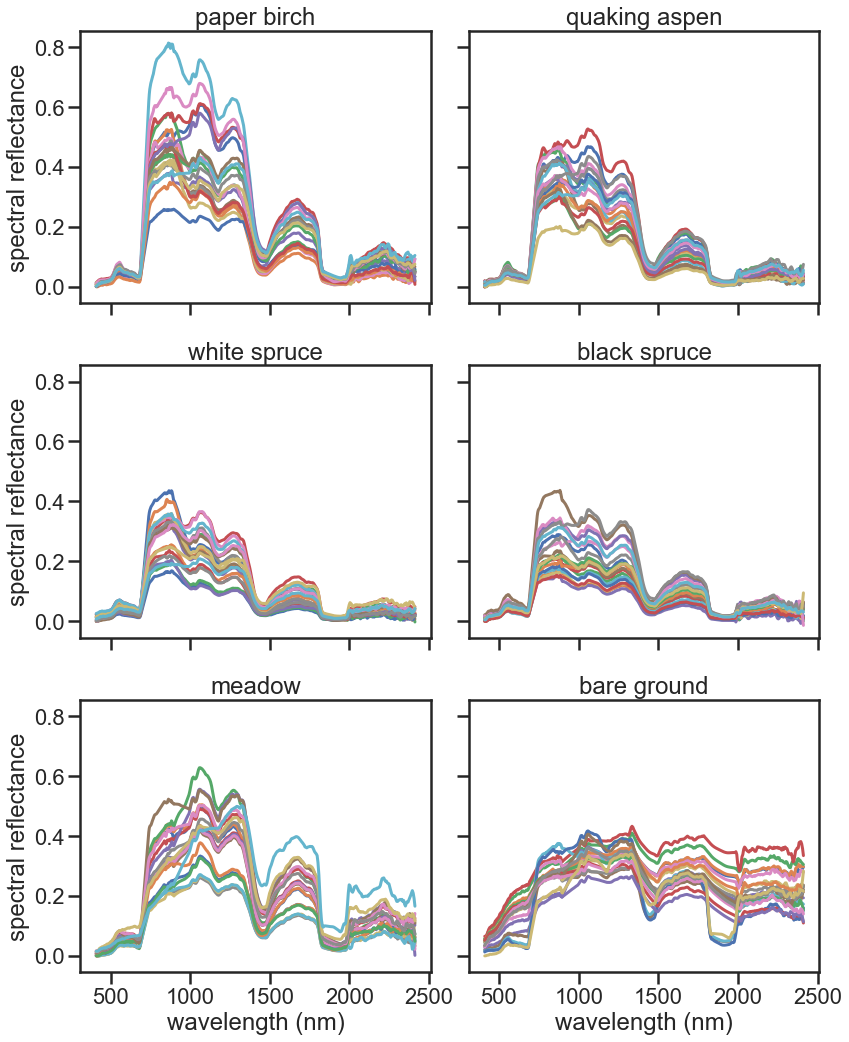

In [54]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharex=True, sharey=True)

for ii, ax in enumerate(axs.flatten()):    
    for spec in spectra_forplot[spectra_forplot['species']==species[ii]].spectrum: 
        ax.plot(hyspex_wavelengths[:-18], munge.smooth_spectrum(spec, clip_bands=8))
        ax.set_title(f"{species_labels[ii]}") 
axs[0, 0].set_ylabel("spectral reflectance")
axs[1, 0].set_ylabel("spectral reflectance")
axs[2, 0].set_ylabel("spectral reflectance")
axs[2, 0].set_xlabel("wavelength (nm)") 
axs[2, 1].set_xlabel("wavelength (nm)") 

plt.tight_layout()   

In [55]:
outdir = Path("../Figures/")
fig.savefig(outdir / "figure4_left.png", dpi=200, bbox_inches='tight', fc='w')

/var/folders/39/6h0p929579n8vrp25cjkbz3h0000gn/T/ipykernel_83874/2274281511.py:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fc" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(outdir / "figure4_left.png", dpi=200, bbox_inches='tight', fc='w')


---

In [117]:
len(samplespectra_fortraining)

119

In [279]:
samplespectra_fortraining = samplespectra
spectra_fortraining = pd.DataFrame.from_records(samplespectra_fortraining)
spectra_fortraining

,fid,species,event,flightline,vegclass,context,spectrum
0,559,white spruce,20210803-BC,04,None,crown,"[108.0, 148.0, 109.0, 138.0, 115.0, 126.0, 127..."
1,562,white spruce,20210803-BC,04,None,crown,"[153.0, 163.0, 192.0, 198.0, 207.0, 211.0, 248..."
2,566,paper birch,20210803-BC,04,None,crown,"[78.0, 74.0, 58.0, 86.0, 82.0, 94.0, 89.0, 142..."
3,568,paper birch,20210803-BC,04,Bluejoint,crown,"[59.0, 57.0, 67.0, 95.0, 100.0, 92.0, 133.0, 1..."
4,571,paper birch,20210803-BC,04,Bluejoint,crown,"[104.0, 113.0, 86.0, 128.0, 137.0, 130.0, 140...."
...,...,...,...,...,...,...,...
114,661,paper birch,20200830-BC,02,Closed Spruce/Paper Birch Forest,crown,"[73.0, 41.0, 55.0, 73.0, 81.0, 56.0, 77.0, 136..."
115,659,paper birch,20200830-BC,02,Closed Spruce/Paper Birch Forest,crown,"[25.0, 21.0, 42.0, 81.0, 69.0, 120.0, 94.0, 11..."
116,689,graminoid,20210803-BC,02,Wet sedge meadow,open,"[128.0, 151.0, 124.0, 107.0, 161.0, 135.0, 180..."
117,685,graminoid,20210803-BC,02,Wet sedge meadow,open,"[152.0, 124.0, 163.0, 155.0, 169.0, 193.0, 238..."


In [140]:
fn = Path("/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq")
with xr.open_dataset(fn, engine="rasterio") as ds:
    ds.attrs['long_name'] = "spectral reflectance, %*100"
    ds.attrs['name'] = "spectral reflectance, %*100"
    ds['band_data'].attrs['long_name']  =  "spectral reflectance, %*100"
    hyspex_wavelengths = ds.wavelength.data

In [35]:
fn = Path("/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq")
testdata = get_dataset(fn)
sampledf = get_singlefilesampledf(row)
pt = sampledf.iloc[0].geometry
testdata.band_data.sel(x=pt.x, y=pt.y, method='nearest').values

array([  142.,   163.,   152.,   144.,   169.,   167.,   167.,   193.,
         161.,   186.,   191.,   197.,   194.,   179.,   186.,   196.,
         193.,   186.,   175.,   185.,   180.,   196.,   214.,   185.,
         206.,   204.,   197.,   214.,   211.,   218.,   225.,   240.,
         241.,   258.,   285.,   301.,   308.,   334.,   339.,   361.,
         370.,   381.,   398.,   393.,   383.,   399.,   399.,   400.,
         394.,   371.,   374.,   377.,   353.,   342.,   339.,   322.,
         324.,   343.,   328.,   318.,   318.,   334.,   318.,   314.,
         312.,   311.,   300.,   302.,   294.,   288.,   300.,   292.,
         277.,   280.,   285.,   269.,   273.,   256.,   257.,   246.,
         236.,   236.,   229.,   229.,   226.,   233.,   237.,   256.,
         364.,   472.,   580.,   689.,   797.,   905.,  1013.,  1121.,
        1230.,  1338.,  1446.,  1554.,  1663.,  1771.,  1879.,  1987.,
        2095.,  2144.,  2158.,  2202.,  2242.,  2281.,  2320.,  2359.,
      

In [64]:
subsample

,fileprefix,flightline,species,vegclass,context,geometry
563,20210803-BC,04,white spruce,None,crown,POINT (436685.995 7178216.899)
423,20210803-BC,03,white spruce,Closed Spruce/Paper Birch Forest,crown,POINT (437026.109 7176200.958)
346,20210803-BC,03,white spruce,Closed Quaking Aspen/White Spruce Forest,crown,POINT (437129.028 7176208.997)
292,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (436972.888 7176336.933)
303,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (437004.009 7176328.798)
...,...,...,...,...,...,...
555,20210803-BC,04,gravel,trail,open,POINT (436724.142 7178207.840)
556,20210803-BC,04,gravel,trail,open,POINT (436724.881 7178205.929)
557,20210803-BC,04,gravel,trail,open,POINT (436725.189 7178197.979)
558,20210803-BC,04,gravel,trail,open,POINT (436725.991 7178193.665)


In [40]:
vegsamples[(vegsamples.fileprefix=='20210803-BC') & (vegsamples.context=='crown') & (vegsamples.species=='white spruce')].sample(n=20)

,fileprefix,flightline,species,vegclass,context,geometry
421,20210803-BC,03,white spruce,Closed Spruce/Paper Birch Forest,crown,POINT (437024.876 7176200.071)
297,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (436984.083 7176329.768)
343,20210803-BC,03,white spruce,Closed Quaking Aspen/White Spruce Forest,crown,POINT (437132.184 7176207.764)
440,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437098.256 7176582.899)
438,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437105.111 7176567.908)
843,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437274.998 7176618.834)
424,20210803-BC,03,white spruce,Closed Spruce/Paper Birch Forest,crown,POINT (437045.884 7176196.915)
442,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437120.004 7176564.949)
303,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (437004.009 7176328.798)
835,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437064.152 7176639.981)


2022-05-09 12:18:17,698 - tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7fdd201e1a30>>, <Task finished name='Task-14' coro=<Worker.close() done, defined at /Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/distributed/worker.py:1385> exception=CommClosedError('ConnectionPool not running. Status: Status.closed')>)
Traceback (most recent call last):
  File "/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/distributed/core.py", line 1089, in connect
    comm = await fut
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/

In [37]:
treespecies = ['paper birch', 'quaking aspen', 'black spruce', 'white spruce']

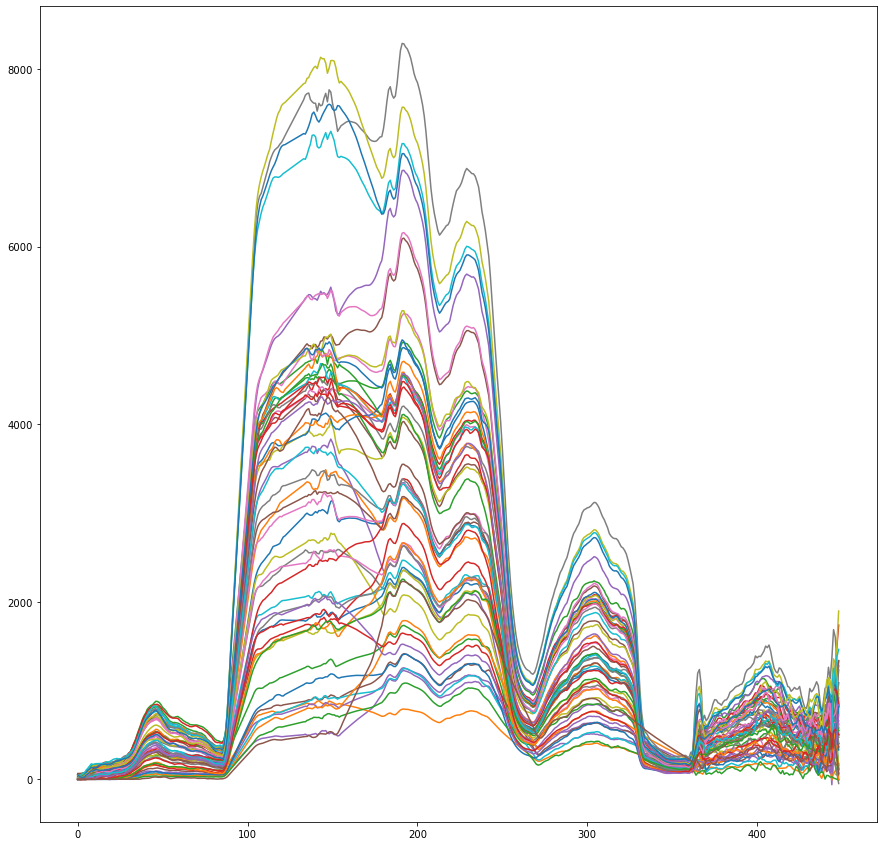

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))

for pt in samples['paper birch']: 
    spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:-10]
    ax.plot(savgol_filter(spec, 7, 2))

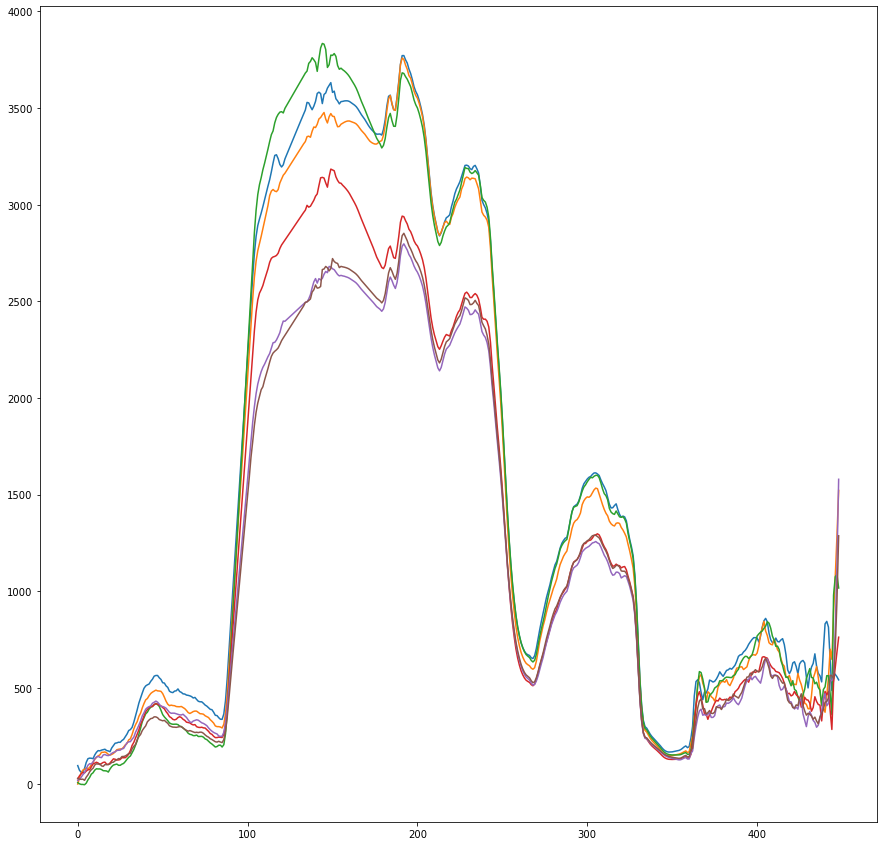

In [18]:
fig, ax = plt.subplots(figsize=(15, 15))

for pt in samples['quaking aspen'][:6]: 
    spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:-10]
    ax.plot(savgol_filter(spec, 7, 2))

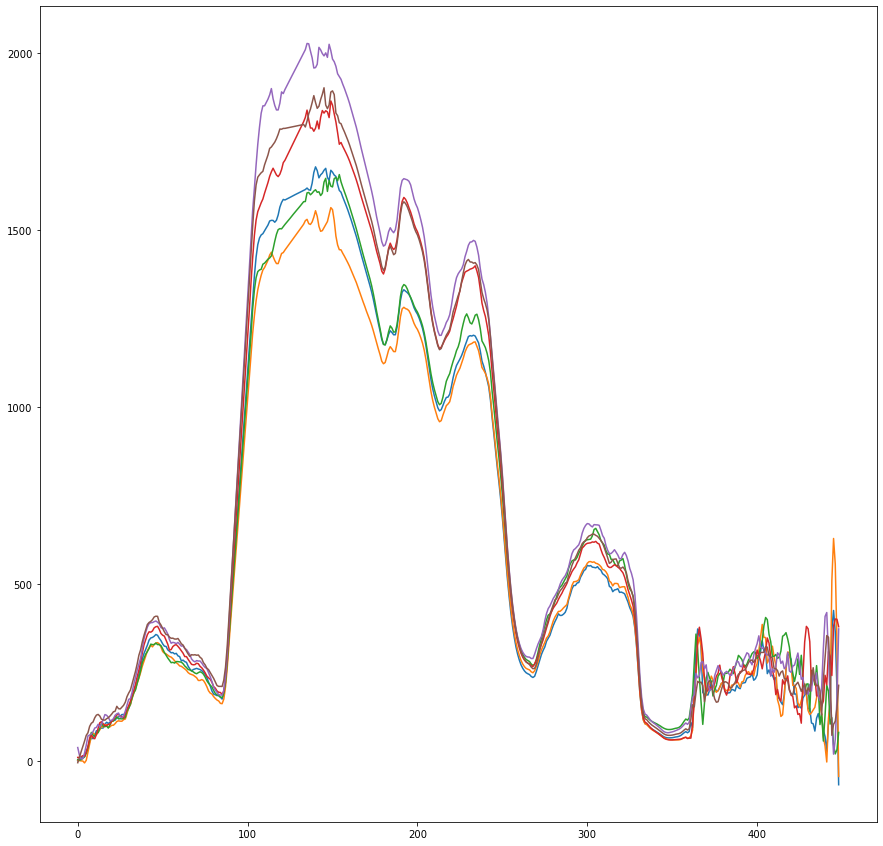

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))

for pt in samples['black spruce'][:6]: 
    spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:-10]
    ax.plot(savgol_filter(spec, 7, 2))

In [26]:
skipSWIR = -15
wavelengths = testdata.wavelength.values[:skipSWIR]

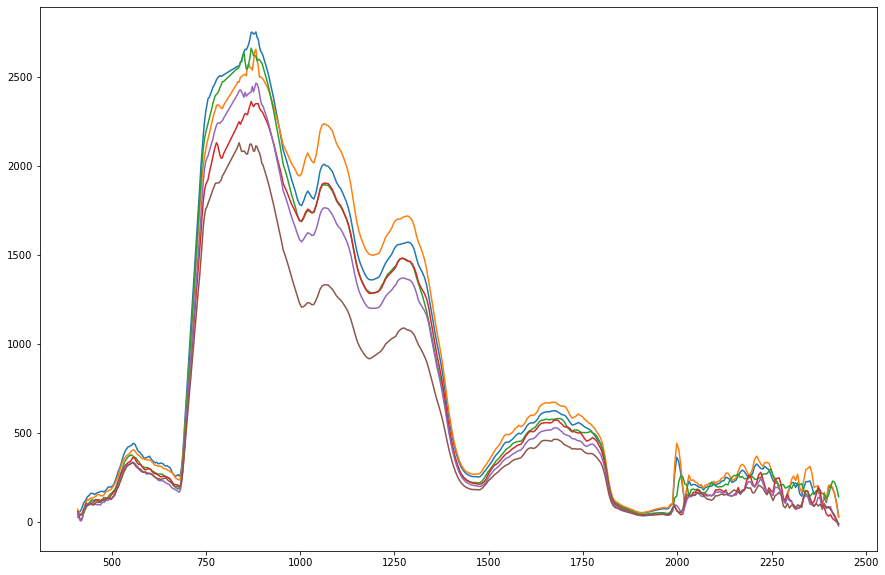

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))

for pt in samples['white spruce'][:6]: 
    spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:skipSWIR]
    ax.plot(wavelengths, savgol_filter(spec, 7, 2))

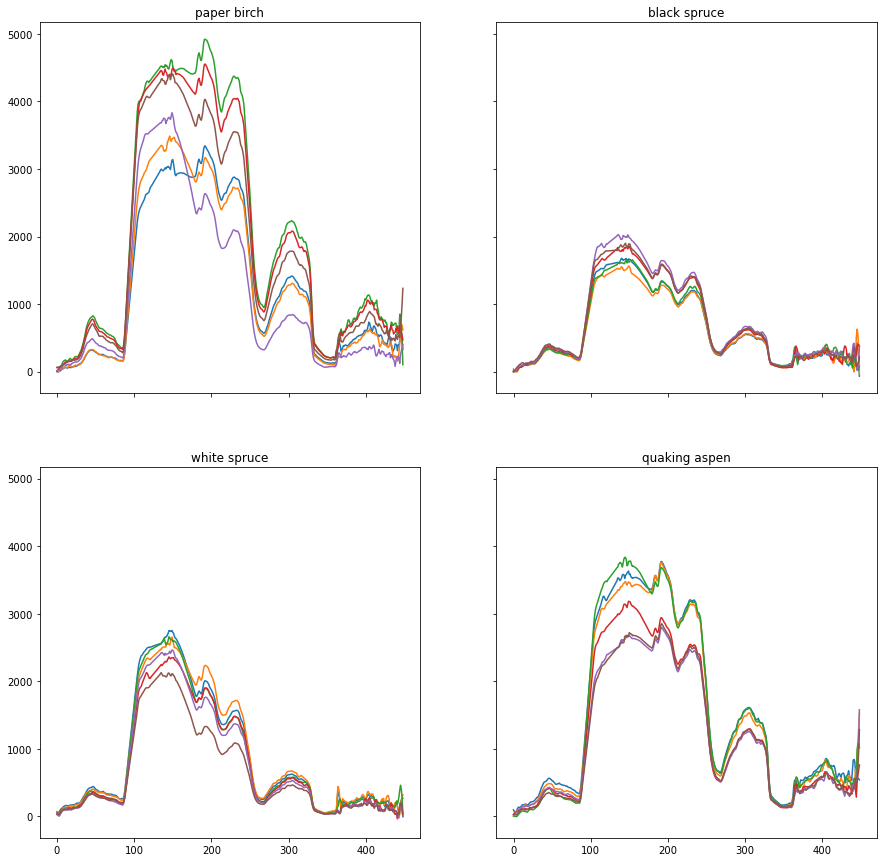

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)


for ii, ax in enumerate(axs.flatten()):
    for pt in samples[speciesnames[ii]][:6]: 
        spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:-10]
        ax.plot(savgol_filter(spec, 7, 2))
        ax.set_title(speciesnames[ii]) 
    

In [43]:
import psutil

proc = psutil.Process()
print(proc.open_files())

[popenfile(path='/Users/christine/.ipython/profile_default/history.sqlite', fd=63), popenfile(path='/Users/christine/.ipython/profile_default/history.sqlite', fd=65), popenfile(path='/Users/christine/miniconda3/envs/python38_geo/share/proj/proj.db', fd=71), popenfile(path='/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop.hdr', fd=132), popenfile(path='/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq', fd=156), popenfile(path='/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_06_VNIR_SWIR_rad_geo_atm_bcor_crop.hdr', fd=158), popenfile(path='/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_06_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq', fd=159), popenfile(path='/Volumes/FIREICE/fihyper/cwaigl/20200830_BC/03_products/cropped_masked_final/20200830-BC_05_VNIR_SWIR_rad_

In [ ]:
testdata